# 03. rajpurohitpooja/Salary_Prediction_Portfolio

## Prediction & XAI with Gradient Boosting (T1) - train_features.csv & test_features.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import lime, shap
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('03_train_features.csv')
df_salary = pd.read_csv('03_train_salaries.csv')

C:\Users\Doğan Yiğit Yenigün\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Merge these two datasets with 'jobId' column; then show all the columns, counts and their data types
df = df.merge(df_salary, on='jobId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [3]:
# First 5 rows of the dataset
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


## Prepare Train and Test Sets

In [4]:
# Create dummy variables from these columns: jobType, degree, major, industry
dummy_jobtype = pd.get_dummies(df['jobType'], prefix='job')
dummy_degree = pd.get_dummies(df['degree'], prefix='deg')
dummy_major = pd.get_dummies(df['major'], prefix='maj')
dummy_industry = pd.get_dummies(df['industry'], prefix='ind')
df_concat = pd.concat([dummy_jobtype, dummy_degree, dummy_major, dummy_industry,
                       df['yearsExperience'], df['milesFromMetropolis'], df['salary']], axis=1)
df_concat.head(10)

,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,job_VICE_PRESIDENT,deg_BACHELORS,deg_DOCTORAL,...,ind_AUTO,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB,yearsExperience,milesFromMetropolis,salary
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,83,130
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,10,38,137
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,8,16,163
5,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,2,31,113
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,23,24,178
7,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,70,73
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,31
9,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,17,68,104


### Type 1: Use All Columns

In [5]:
# Use 80% of the dataset as train set, and 20% as test set
X = df_concat.drop(columns='salary', axis=1)
Y = df_concat.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)

TRAIN SIZE: (800000, 31) (800000,)   TEST SIZE: (200000, 31) (200000,)


## Predict with Gradient Boosting Regression

In [6]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [7]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 90.565 seconds.


In [8]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1E05048D840)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1E05048D840)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1E05048D840)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1E05048D840)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1E05048D840)]]
# OF ESTIMATORS: 100
# OF FEATURES: 31
MAX FEATURES: 31
FEATURE IMPORTANCES: [6.09678135e-02 2.52591000e-02 2.70740511e-02 1.98380494e-01
 7.51156712e-02 3.30378922e-03 3.00889988e-02 1.53049348e-03
 2.24693114e-05 1.39594233e-02 0.00000000e+00 4.3054514

In [9]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   95.56515709260711 |       73
  121.05466476233431 |      100
  126.56726431833545 |      101
  127.12494870642804 |      112
  117.39881082116932 |      130
   114.9341945740333 |      108
  121.27123075001697 |      130
   61.29715524302028 |       43
   174.4784977671971 |      174
   93.89969166788136 |       88
  107.90136502631204 |      103
   171.9936103826718 |      162
    89.3931904641482 |       73
  107.01066555835001 |       96
  127.44931393445339 |      121
  158.06788096620048 |      187
   143.3804639960032 |      173
   95.10202603778522 |       89
  106.70245988536693 |      106
  126.97591525463226 |      160


In [12]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-gradBoost.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
print("ADJUSTED R2 SCORE:", adj_r2)   # Adjusted R2 score
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
# The time in seconds for fitting the estimator on the train set for each cv split
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# The time in seconds for scoring the estimator on the test set for each cv split
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# The score array for train scores for each cv split
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
# The score array for test score for each cv split
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())

MSE: 376.86945572580146
RMSE: 19.41312586179262
MAE: 15.696993660106159
R2 SCORE: 0.7496506094270023
ADJUSTED R2 SCORE: 0.749642938347851

# CROSS VALIDATION #
FITTING TIME: [ 90.50294495  90.19688702  98.48087096 110.13209319 120.77002978] -> 102.01656517982482
SCORING TIME: [0.37579036 0.40496922 0.52042699 0.45532274 0.44058371] -> 0.4394186019897461
TRAIN SCORE: [0.75009802 0.74972787 0.74996668 0.7499044  0.74962531] -> 0.7498644544786458
TEST SCORE: [0.748973   0.74927833 0.74912566 0.74997693 0.749924  ] -> 0.7494555830447164


## Explain the Model with SHAP

In [13]:
shap.initjs()
shap_explainer = shap.Explainer(gradBoost, x_train)
shap_values = shap_explainer(x_test)
print(shap_values.shape)
print(shap_values)
print("\n EXPECTED VALUE:", shap_explainer.expected_value)

100%|===================| 199929/200000 [03:18<00:00]        

(200000, 31)
.values =
array([[ -3.3515042 ,  -1.2771109 ,  -1.79627711, ...,  -0.81364513,
         -0.21338369,   5.79529193],
       [ -2.70106273,  -0.79936071,   9.52660288, ...,  -0.81364513,
          2.27283514,  -1.72662796],
       [ -3.37493873,  -1.24286376,  -1.73136224, ...,  -0.43701764,
          4.21394249,  -1.59695408],
       ...,
       [ -3.30176653,  -1.23995172,  -1.70238074, ...,  -0.43300986,
        -17.92071779,   4.62633707],
       [ -3.01548571,  -1.14447094,  -1.5748817 , ...,   3.9831053 ,
        -16.16219061, -11.78388566],
       [ -3.23099493,  -1.16869886,  -1.6948607 , ...,  -0.81233898,
        -18.22872845,  -9.35008923]])

.base_values =
array([121.92447487, 121.92447487, 121.92447487, ..., 121.92447487,
       121.92447487, 121.92447487])

.data =
array([[ 0,  0,  0, ...,  0, 13, 33],
       [ 0,  0,  1, ...,  0, 14, 54],
       [ 0,  0,  0, ...,  0, 15, 53],
       ...,
       [ 0,  0,  0, ...,  0,  4, 34],
       [ 0,  0,  0, ...,  1,  2, 90

### SUMMARY OF EXPLAINABILITY WITH SHAP ###


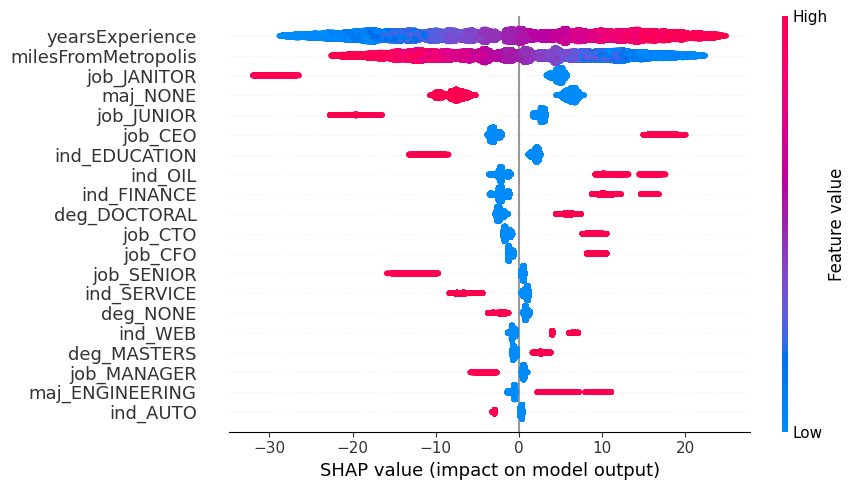

In [14]:
print("### SUMMARY OF EXPLAINABILITY WITH SHAP ###")
# shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values, x_test, plot_type='dot', plot_size=[9,5])

In [16]:
print("### VISUALIZATION OF FIRST 500 PREDICTIONS ###")
shap.plots.force(shap_values[:500])

### VISUALIZATION OF FIRST 500 PREDICTIONS ###


### MEAN ABSOLUTE VALUES OF SHAP VALUES ###


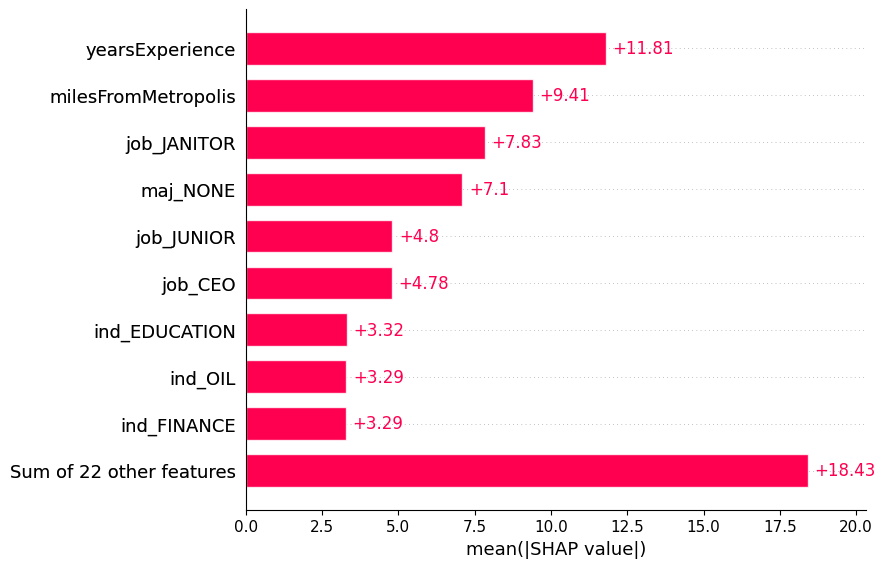

In [17]:
print("### MEAN ABSOLUTE VALUES OF SHAP VALUES ###")
shap.plots.bar(shap_values)

### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###


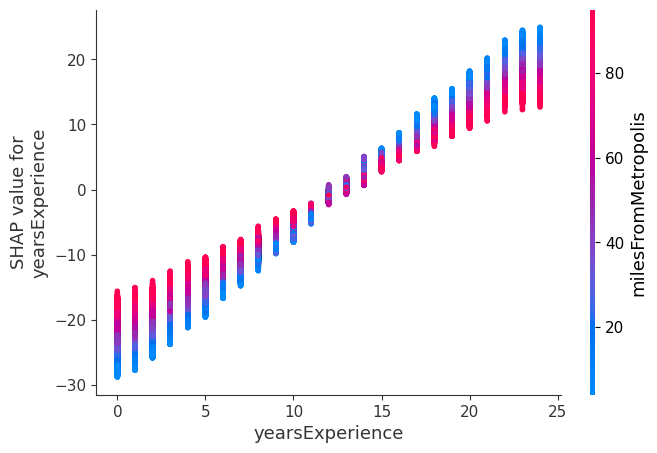

In [18]:
print("### DEPENDENCY BETWEEN THE FIRST COLUMN & THE BEST INTERACTION ###")
shap.dependence_plot("yearsExperience", shap_values.values, x_test)

### EXPLAINING TEST ROW 90593 WITH SHAP ###


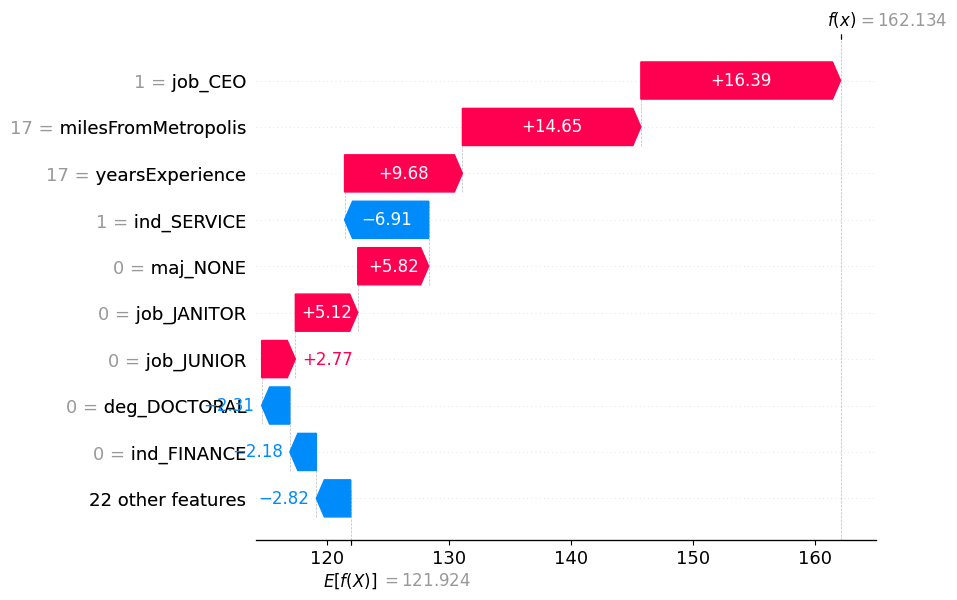

In [19]:
# i = 0
import random
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.waterfall(shap_values[i])

In [20]:
print("### EXPLAINING TEST ROW {} WITH SHAP ###".format(i))
shap.plots.force(shap_values[i])

### EXPLAINING TEST ROW 90593 WITH SHAP ###


## Explain the Model with LIME

In [21]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=df_concat.columns, 
                                                        class_names=['salary'], verbose=True, mode='regression')

In [22]:
i = random.randint(0, x_test.shape[0]-1)
print("### EXPLAINING TEST ROW {} WITH LIME ###".format(i))
exp = lime_explainer.explain_instance(x_test.iloc[i], gradBoost.predict, num_features=10)
exp.show_in_notebook(show_table=True)
exp.as_list()

### EXPLAINING TEST ROW 158104 WITH LIME ###
Intercept 96.9051495591046
Prediction_local [105.19266237]
Right: 90.93104898411197


[('job_JANITOR <= 0.00', 32.56793727627081),
 ('yearsExperience <= 6.00', -23.786997067481828),
 ('job_JUNIOR <= 0.00', 20.36913558983312),
 ('job_CEO <= 0.00', -18.92684460447891),
 ('0.00 < maj_NONE <= 1.00', -13.923983757291568),
 ('ind_EDUCATION <= 0.00', 11.886286463632565),
 ('job_SENIOR <= 0.00', 11.673737736542504),
 ('ind_FINANCE <= 0.00', -11.626955474350885),
 ('job_CTO > 0.00', 9.62026269983766),
 ('ind_OIL <= 0.00', -9.56506604891129)]